In [2]:
import os
import zipfile
import urllib.request

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
zip_path = "uci_har.zip"

if not os.path.exists("UCI HAR Dataset"):
    urllib.request.urlretrieve(url, zip_path)
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall()
    print("Dataset downloaded and extracted.")
else:
    print("Dataset already exists.")


Dataset downloaded and extracted.


In [4]:
import numpy as np

def load_signals(signal_type, split="train"):
    path = f"UCI HAR Dataset/{split}/Inertial Signals/"
    files = [
        f"{signal_type}_x_{split}.txt",
        f"{signal_type}_y_{split}.txt",
        f"{signal_type}_z_{split}.txt"
    ]
    signals = [np.loadtxt(path + f) for f in files]
    return np.stack(signals, axis=2)

# Accelerometer and Gyroscope
acc = load_signals("body_acc", "train")
gyro = load_signals("body_gyro", "train")

print("Accelerometer shape:", acc.shape)
print("Gyroscope shape:", gyro.shape)


Accelerometer shape: (7352, 128, 3)
Gyroscope shape: (7352, 128, 3)


In [5]:
y = np.loadtxt("UCI HAR Dataset/train/y_train.txt").astype(int)

activity_map = {
    1: "WALKING",
    2: "WALKING_UPSTAIRS",
    3: "WALKING_DOWNSTAIRS",
    4: "SITTING",
    5: "STANDING",
    6: "LAYING"
}

unique, counts = np.unique(y, return_counts=True)
means = {activity_map[k]: v for k, v in zip(unique, counts)}
print("Activity distribution:", means)


Activity distribution: {'WALKING': np.int64(1226), 'WALKING_UPSTAIRS': np.int64(1073), 'WALKING_DOWNSTAIRS': np.int64(986), 'SITTING': np.int64(1286), 'STANDING': np.int64(1374), 'LAYING': np.int64(1407)}


In [6]:
from scipy.signal import butter, filtfilt

def lowpass_filter(signal, cutoff=3.0, fs=50, order=4):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return filtfilt(b, a, signal, axis=1)


In [7]:
acc_filt = lowpass_filter(acc)
gyro_filt = lowpass_filter(gyro)

print("Filtered accelerometer shape:", acc_filt.shape)
print("Filtered gyroscope shape:", gyro_filt.shape)


Filtered accelerometer shape: (7352, 128, 3)
Filtered gyroscope shape: (7352, 128, 3)


In [8]:
import numpy as np

def magnitude(signal):
    return np.sqrt(np.sum(signal ** 2, axis=2))

acc_mag = magnitude(acc_filt)
gyro_mag = magnitude(gyro_filt)

print("Accelerometer magnitude shape:", acc_mag.shape)
print("Gyroscope magnitude shape:", gyro_mag.shape)


Accelerometer magnitude shape: (7352, 128)
Gyroscope magnitude shape: (7352, 128)


In [9]:
# Gait activity labels
gait_labels = [1, 2, 3]  # walking, upstairs, downstairs

gait_idx = np.isin(y, gait_labels)

acc_gait = acc_mag[gait_idx]
gyro_gait = gyro_mag[gait_idx]
y_gait = y[gait_idx]

print("Gait samples:", acc_gait.shape[0])


Gait samples: 3285


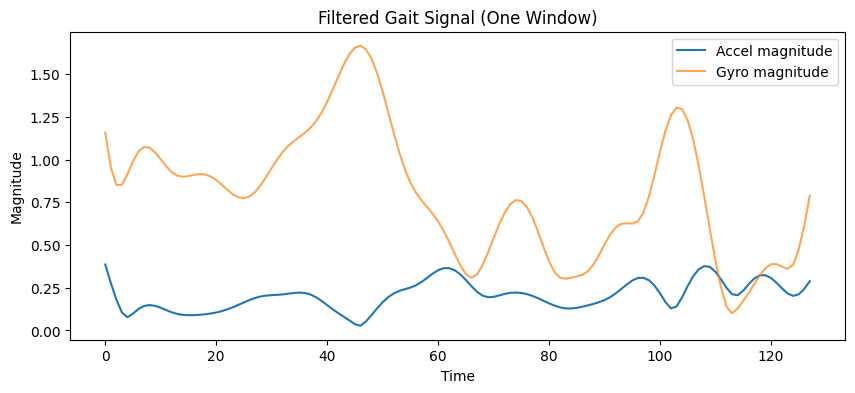

In [10]:
import matplotlib.pyplot as plt

sample_id = 0

plt.figure(figsize=(10, 4))
plt.plot(acc_gait[sample_id], label="Accel magnitude")
plt.plot(gyro_gait[sample_id], label="Gyro magnitude", alpha=0.7)
plt.title("Filtered Gait Signal (One Window)")
plt.xlabel("Time")
plt.ylabel("Magnitude")
plt.legend()
plt.show()


In [11]:
from scipy.signal import find_peaks

def compute_jerk(signal):
    # Jerk = derivative of acceleration
    jerk = np.diff(signal, axis=1)
    return np.mean(np.abs(jerk), axis=1)

def step_regularities(signal):
    regs = []
    for s in signal:
        peaks, _ = find_peaks(s, distance=15)
        if len(peaks) > 2:
            intervals = np.diff(peaks)
            regs.append(np.std(intervals))
        else:
            regs.append(0)
    return np.array(regs)


In [12]:
def extract_gait_features(acc_signal, gyro_signal):
    features = {}

    # Stability (lower = better)
    features["acc_variance"] = np.var(acc_signal, axis=1)

    # Smoothness
    features["acc_jerk"] = compute_jerk(acc_signal)

    # Step regularity (lower std = more rhythmic)
    features["step_regularity"] = step_regularities(acc_signal)

    # Energy proxy
    features["acc_energy"] = np.sum(acc_signal ** 2, axis=1)

    # Balance proxy
    features["gyro_variance"] = np.var(gyro_signal, axis=1)

    return features


In [13]:
features = extract_gait_features(acc_gait, gyro_gait)

for k in features:
    print(k, features[k].shape)


acc_variance (3285,)
acc_jerk (3285,)
step_regularity (3285,)
acc_energy (3285,)
gyro_variance (3285,)


In [14]:
import pandas as pd

df_features = pd.DataFrame(features)
df_features["activity"] = y_gait

df_features.head()


,acc_variance,acc_jerk,step_regularity,acc_energy,gyro_variance,activity
0,0.006705,0.019645,8.956686,6.113394,0.139947,1
1,0.006123,0.024452,5.787918,7.551352,0.089336,1
2,0.004857,0.021860,3.633180,7.335936,0.071949,1
3,0.008552,0.026352,0.829156,8.841952,0.103014,1
4,0.006243,0.025814,2.059126,9.418998,0.111157,1


In [15]:
df_features.describe()


,acc_variance,acc_jerk,step_regularity,acc_energy,gyro_variance,activity
count,3285.000000,3285.000000,3285.000000,3285.000000,3285.000000,3285.000000
mean,0.010660,0.032576,5.588881,11.632966,0.099239,1.926941
std,0.008139,0.017547,3.049106,5.387890,0.091648,0.817453
min,0.001079,0.006016,0.000000,2.167303,0.005306,1.000000
25%,0.004710,0.019998,3.299832,7.450975,0.040752,1.000000
50%,0.007816,0.026577,5.539630,10.467326,0.073475,2.000000
75%,0.014808,0.040374,7.433034,14.712196,0.124969,3.000000
max,0.046702,0.102181,17.268106,37.834941,1.136014,3.000000


In [16]:
df_healthy = df_features.copy()
df_healthy["week"] = 0  # baseline


In [17]:
import numpy as np

def simulate_stroke(df, severity=1.0):
    df_sim = df.copy()

    df_sim["acc_variance"] *= (1 + 0.8 * severity)
    df_sim["acc_jerk"] *= (1 + 1.0 * severity)
    df_sim["step_regularity"] *= (1 + 0.9 * severity)
    df_sim["gyro_variance"] *= (1 + 0.7 * severity)
    df_sim["acc_energy"] *= (1 - 0.4 * severity)

    return df_sim


In [18]:
weeks = []

weeks.append(simulate_stroke(df_healthy, severity=1.0).assign(week=1))
weeks.append(simulate_stroke(df_healthy, severity=0.6).assign(week=2))
weeks.append(simulate_stroke(df_healthy, severity=0.3).assign(week=3))
weeks.append(simulate_stroke(df_healthy, severity=0.1).assign(week=4))

df_rehab = pd.concat([df_healthy] + weeks, ignore_index=True)


In [19]:
df_rehab.groupby("week").mean()[[
    "acc_variance",
    "acc_jerk",
    "step_regularity",
    "gyro_variance",
    "acc_energy"
]]


,acc_variance,acc_jerk,step_regularity,gyro_variance,acc_energy
week,,,,,
0,0.010660,0.032576,5.588881,0.099239,11.632966
1,0.019187,0.065152,10.618875,0.168707,6.979779
2,0.015776,0.052121,8.606877,0.140920,8.841054
3,0.013218,0.042349,7.097879,0.120080,10.237010
4,0.011512,0.035833,6.091881,0.106186,11.167647


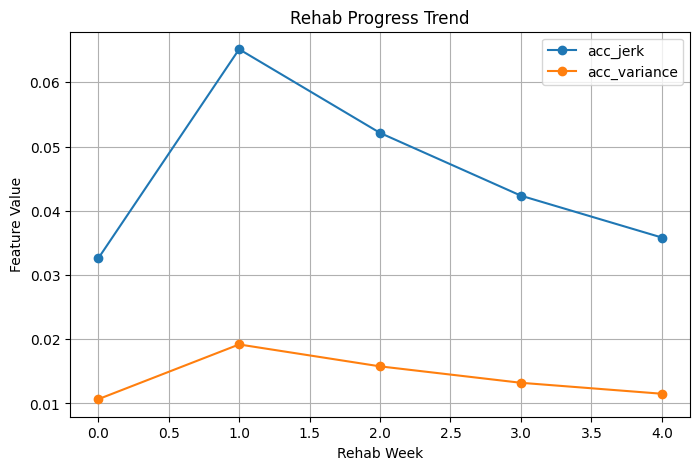

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
for f in ["acc_jerk", "acc_variance"]:
    plt.plot(
        df_rehab.groupby("week")[f].mean(),
        marker="o",
        label=f
    )

plt.xlabel("Rehab Week")
plt.ylabel("Feature Value")
plt.title("Rehab Progress Trend")
plt.legend()
plt.grid()
plt.show()


In [21]:
from sklearn.preprocessing import MinMaxScaler

score_features = [
    "acc_variance",
    "acc_jerk",
    "step_regularity",
    "gyro_variance",
    "acc_energy"
]

df_score = df_rehab.copy()

# Normalize each feature across all weeks
scaler = MinMaxScaler()
df_score[score_features] = scaler.fit_transform(df_score[score_features])


In [22]:
bad_features = [
    "acc_variance",
    "acc_jerk",
    "step_regularity",
    "gyro_variance"
]

for f in bad_features:
    df_score[f] = 1 - df_score[f]


In [23]:
df_score["rehab_score"] = df_score[score_features].mean(axis=1) * 100


In [24]:
df_score.groupby("week")["rehab_score"].mean()


,rehab_score
week,
0,76.286851
1,64.612006
2,69.281944
3,72.784397
4,75.119366


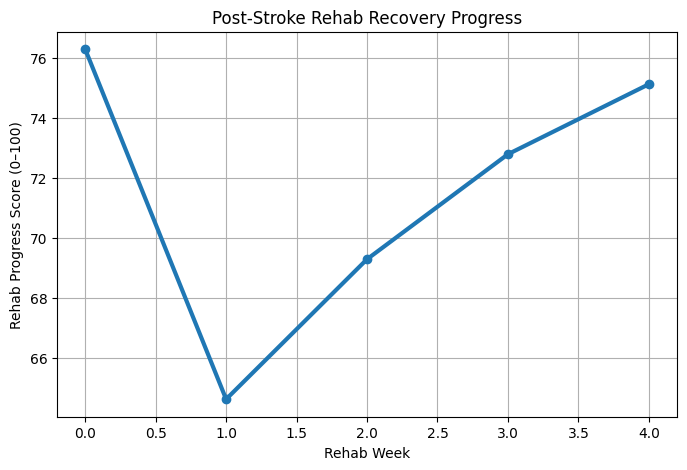

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(
    df_score.groupby("week")["rehab_score"].mean(),
    marker="o",
    linewidth=3
)
plt.xlabel("Rehab Week")
plt.ylabel("Rehab Progress Score (0–100)")
plt.title("Post-Stroke Rehab Recovery Progress")
plt.grid(True)
plt.show()


In [26]:
from sklearn.model_selection import train_test_split

feature_cols = [
    "acc_variance",
    "acc_jerk",
    "step_regularity",
    "gyro_variance",
    "acc_energy"
]

X = df_score[feature_cols]
y = df_score["rehab_score"]


In [27]:
train_idx = df_score["week"] <= 2
test_idx  = df_score["week"] > 2

X_train, X_test = X[train_idx], X[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

print("Train samples:", X_train.shape[0])
print("Test samples:", X_test.shape[0])


Train samples: 9855
Test samples: 6570


In [28]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

print("Model trained.")


Model trained.


In [29]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("MAE:", round(mae, 2))
print("R2 Score:", round(r2, 3))


MAE: 0.0
R2 Score: 1.0


In [30]:
import pandas as pd

pd.DataFrame({
    "Actual_RSI": y_test.values[:10],
    "Predicted_RSI": y_pred[:10]
})


,Actual_RSI,Predicted_RSI
0,69.883583,69.883583
1,73.209283,73.209283
2,75.710080,75.710080
3,76.523011,76.523011
4,76.506931,76.506931
5,73.536246,73.536246
6,76.994429,76.994429
7,75.873446,75.873446
8,72.029590,72.029590
9,71.792250,71.792250


In [31]:
import numpy as np

X_noisy = X.copy()

noise_level = 0.05  # 5% noise
for col in feature_cols:
    std = X_noisy[col].std()
    X_noisy[col] += np.random.normal(0, noise_level * std, size=len(X_noisy))


In [32]:
Xn_train = X_noisy[train_idx]
Xn_test  = X_noisy[test_idx]

y_train = y[train_idx]
y_test  = y[test_idx]


In [33]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=6,
    random_state=42
)

rf.fit(Xn_train, y_train)
print("Random Forest trained.")


Random Forest trained.


In [34]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred_rf = rf.predict(Xn_test)

mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("RF MAE:", round(mae_rf, 2))
print("RF R2:", round(r2_rf, 3))


RF MAE: 1.31
RF R2: 0.734


In [35]:
import pandas as pd

pd.Series(
    rf.feature_importances_,
    index=feature_cols
).sort_values(ascending=False)


,0
acc_jerk,0.523185
step_regularity,0.394317
acc_energy,0.044222
acc_variance,0.023348
gyro_variance,0.014927


In [36]:
def predict_patient_rsi(feature_dict, model, scaler=None):
    """
    feature_dict = {
        'acc_variance': float,
        'acc_jerk': float,
        'step_regularity': float,
        'gyro_variance': float,
        'acc_energy': float
    }
    """

    import pandas as pd

    df = pd.DataFrame([feature_dict])

    # If scaler was used (optional)
    if scaler is not None:
        df[df.columns] = scaler.transform(df[df.columns])

    rsi = model.predict(df)[0]
    return round(float(rsi), 2)


demo


In [37]:
sample_patient = {
    "acc_variance": Xn_test.iloc[0]["acc_variance"],
    "acc_jerk": Xn_test.iloc[0]["acc_jerk"],
    "step_regularity": Xn_test.iloc[0]["step_regularity"],
    "gyro_variance": Xn_test.iloc[0]["gyro_variance"],
    "acc_energy": Xn_test.iloc[0]["acc_energy"]
}

predict_patient_rsi(sample_patient, rf)


71.38

In [38]:
import pickle

with open("rehab_rsi_model.pkl", "wb") as f:
    pickle.dump(rf, f)

print("Model saved as rehab_rsi_model.pkl")


Model saved as rehab_rsi_model.pkl
